In [93]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [94]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [95]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [96]:
# create engine to hawaii.sqlite
engine1 = create_engine("sqlite:///Resources/hawaii.sqlite")
engine = engine1.connect()

In [97]:
# Get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [98]:
# Get column names and types
for t in inspector.get_table_names():
    print('\n'+t)
    columns = inspector.get_columns(t)
    for c in columns:
        print(c['name'], c["type"])


measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [99]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [100]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [101]:
# Find the most recent date in the data set.
dates = session.query(Measurement.date)
# can use max function because dates are formatted as YYYY-MM-DD
most_recent_date= max(dates)[0]
print(most_recent_date)

2017-08-23


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-24'),
  Text(500.0, 0, '2016-11-10'),
  Text(1000.0, 0, '2017-01-29'),
  Text(1500.0, 0, '2017-04-19'),
  Text(2000.0, 0, '2017-07-11'),
  Text(2500.0, 0, '')])

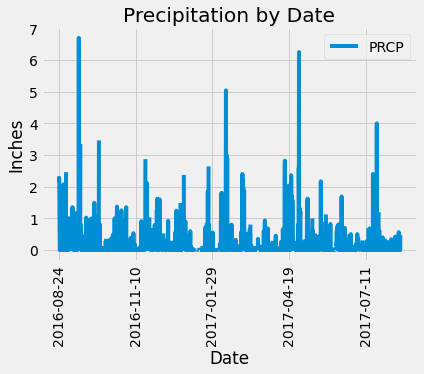

In [102]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt
# Subtracts one year
startdate1 = str(int(most_recent_date[0:4]) - 1) + most_recent_date[4:]
startdate = dt.datetime(int(startdate1.split('-')[0]),
                       int(startdate1.split('-')[1]),
                       int(startdate1.split('-')[2]))

# Perform a query to retrieve the data and precipitation scores
results = session.query(
                       Measurement.date, 
                       Measurement.prcp).filter(Measurement.date >= startdate).all()

# Design a query to calculate the PTP for stock `IBM` after May, 2011
# import datetime as dt

# date = dt.datetime(2011, 5, 31)

# results = session.query(Dow.high_price - Dow.low_price, 
#                         Dow.date).\
#                   filter(Dow.date > date).filter(Dow.stock == 'IBM').all()

# # List comprehension solution
# ptp_rows = [{"Date": result[1], "PTP": result[0]} for result in results]
# ptp_rows




# Save the query results as a Pandas DataFrame and set the index to the date column
df_list = [{
           "Date": result[0], "PRCP": result[1]} for result in results]
df = (pd.DataFrame(df_list)).set_index('Date')
df = df.sort_values(by='Date')



# Use Pandas Plotting with Matplotlib to plot the data


ax = df.plot(title="Precipitation by Date",  ylabel="Inches")
plt.xticks(rotation=90)

In [103]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = df['PRCP'].describe()
stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: PRCP, dtype: float64

# Exploratory Station Analysis

In [104]:
# Design a query to calculate the total number stations in the dataset
stations_num = engine.execute('SELECT COUNT(id) FROM station').first()
stations_num[0]

9

In [105]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_count = engine.execute('SELECT station, COUNT(station) as station_count FROM measurement GROUP BY station ORDER BY station_count DESC').fetchall()
print(stations_count)
# most active station 
most_act = stations_count[0][0]
most_act

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


'USC00519281'

In [106]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
tempinfo = session.query(*sel).filter(Measurement.station == most_act).all()
tempinfo

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

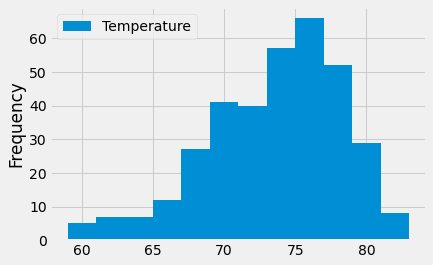

In [107]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
resultstobs = session.query( Measurement.station,
                       Measurement.date, 
                       Measurement.tobs).filter(Measurement.date >= startdate).filter(Measurement.station == most_act).all()
df_list1 = [{"Date": result[1], "Temperature": result[2]} for result in resultstobs]
df1 = (pd.DataFrame(df_list1).sort_values(by='Date')).set_index('Date')


df1
# Use Pandas Plotting with Matplotlib to plot the data

df1.plot.hist(by='Temperature', bins=12,  ylabel="Frequency" )

# Close session

In [108]:
# Close Session
session.close()